### 1. Загрузите данные и подготовьте их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
visits, orders, costs = (
   pd.read_csv('/datasets/visits_info_short.csv'),  
   pd.read_csv('/datasets/orders_info_short.csv'),  
   pd.read_csv('/datasets/costs_info_short.csv')  
)


#### 1.1 Рассмотрим поочередно каждый файл. 
Начнем с визитов

In [3]:
display(visits)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
...,...,...,...,...,...,...
309896,329994900775,UK,PC,LeapBob,2019-10-31 13:28:12,2019-10-31 14:39:29
309897,334903592310,France,PC,lambdaMediaAds,2019-10-31 22:14:52,2019-10-31 22:39:36
309898,540102010126,Germany,PC,organic,2019-10-31 01:40:48,2019-10-31 01:41:31
309899,308736936846,Germany,Mac,organic,2019-10-31 07:37:34,2019-10-31 07:37:55


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [5]:
# Приведем названия столбцов в соответствие с хорошим стилем
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']

In [6]:
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [7]:
# Подсчитаем явные дубликаты 
visits.duplicated().sum()

0

In [8]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

In [9]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

#### Как видно явных  дубликатов не наблюдается. Вывели уникальные названия источников переходов и названия стран. Имеются данные о пользователях из 4х стран - США, Англии, Франции, Германии. Пропуски отсутствуют

In [10]:
# Посмотрим на покупателей
visits['user_id'].value_counts()

33606575057     46
943775408561    36
901180916748    35
870784569391    34
764086596354    33
                ..
350468480225     1
748123264144     1
909267360937     1
816252757222     1
425788122907     1
Name: user_id, Length: 150008, dtype: int64

#### Как видно самый активный покупатель с id 33606575057 . На его счету 46 покупок

In [11]:
# Посмотрим на страны
visits['region'].value_counts()

United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

#### Подавляющее большинство покупателей из США

In [12]:
# Посмотрим на тип устройства пользователя
visits['device'].value_counts()

iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

#### С некотоорым отрывом в логах лидируют пользователи с iPhone

In [13]:
# Посмотрим на источники переходов
visits['channel'].value_counts()

organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64

#### По каналам переходов с большим отрывом лидируют посетители, приходящие через бесплатную выдачу поисковой системы

In [14]:
# преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'], format="%Y.%m.%d %H:%M")
visits['session_end'] = pd.to_datetime(visits['session_end'], format="%Y.%m.%d %H:%M")

In [15]:
#регион, устройство и канал приведем к строковому типу
visits['region'] = visits['region'].astype(str)
visits['device'] = visits['device'].astype(str)
visits['channel'] = visits['channel'].astype(str)

In [16]:
# проверим
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


#### 1.2 Заказы

In [17]:
display(orders)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


In [18]:
orders.columns = ['user_id', 'event_dt', 'revenue']

In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [20]:
orders.isna().sum()

user_id     0
event_dt    0
revenue     0
dtype: int64

In [21]:
orders.duplicated().sum()

0

#### Явных  дубликатов не наблюдается. Пропуски отсутствуют

In [22]:
orders['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

#### В среднем каждый заказ совершается на сумму 5.37 у.е. Медиана и среднее практически не отличаются, можно предположить, что сильных выбрососв в данных нет. Квантили все равны 4.99 - возможно это стоимость подписки. Максимальный заказ был на 49,99 у.е.

In [23]:
# преобразуем данные о времени
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format="%Y-%m-%d %H:%M")

In [24]:
# проверим
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


#### 1.3 Расходы

In [25]:
display(costs)

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


In [26]:
costs.columns = ['dt','channel','costs']

In [27]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [28]:
costs.isna().sum()

dt         0
channel    0
costs      0
dtype: int64

In [29]:
costs.duplicated().sum()

0

In [30]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

In [31]:
# преобразование данных о времени
#costs['dt'] = pd.to_datetime(costs['dt']).dt.date 
costs['dt'] = pd.to_datetime(costs['dt'], format="%Y-%m-%d")

In [32]:
#канал приведем к строковому типу
costs['channel'] = costs['channel'].astype('str')

#### Явных  дубликатов не наблюдается. Вывели уникальные названия рекламных источников. Пропуски отсутствуют

In [33]:
# Посмотрим на рекламные источники
costs['channel'].value_counts()

OppleCreativeMedia    180
YRabbit               180
TipTop                180
FaceBoom              180
MediaTornado          180
RocketSuperAds        180
LeapBob               180
lambdaMediaAds        180
AdNonSense            180
WahooNetBanner        180
Name: channel, dtype: int64

#### Количество контрактов на рекламу распределено равномерно между рекламодателями

In [34]:
costs.describe()

,costs
count,1800.000000
mean,58.609611
std,107.740223
min,0.800000
25%,6.495000
50%,12.285000
75%,33.600000
max,630.000000


#### А вот стоимость контрактов на рекламу разнится. Максимальная трата на маркетинг - 630 у.е., минимальная - 0.8. Cредние и медианные затраты на маркетинг отличаются (58.6 и 12.2 соответственно) - видны выбросы в сторону отдельных больших рекламных контрактов.

### Вывод по разделу
1. Исследовали данные - пропусков нет, дубликатов нет. Преобразовали столбцы с данными о дате и времени. Привели названия столбцов к "змеиному стилю".
2. В задании имеется 150008 уникальных пользователя из 4-х стран - США, Англии, Франции, Германии. Самый активный покупатель с id 33606575057 совершил 46 покупок. Подавляющее большинство покупателей из США. С некоторым отрывом в логах лидируют пользователи с iPhone. По каналам переходов с большим отрывом лидируют посетители, приходящие через бесплатную выдачу поисковой системы.
3. В среднем каждый заказ совершается на сумму 5.37 у.е. Медиана и среднее практически не отличаются, можно предположить, что сильных выбрососв в данных нет. Квантили все равны 4.99 - возможно это стоимость подписки. Максимальный заказ был на 49,99 у.е.
4. Количество контрактов на рекламу распределено равномерно между 10 рекламодателями (по 180) - 'FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit', 'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner', 'lambdaMediaAds'. А вот стоимость контрактов на рекламу разнится. Максимальная трата на маркетинг - 630 у.е., минимальная - 0.8. Cредние и медианные затраты на маркетинг отличаются (58.6 и 12.2 соответственно) - видны выбросы в сторону отдельных больших рекламных контрактов.

### 2. Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Берем момент анализа на 01.11.2019, а горизонт анализа - 14 дней. 

Из расчетов нам следует исключить пользователей с органическим трафиком, поскольку мы за них ничего не платим.

In [35]:
import time
from datetime import datetime
from datetime import date, timedelta as td

observation_date = datetime(2019, 11, 1).date()  # момент анализа 
horizon_days = 14  # горизонт анализа 

In [36]:
# функция для расчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

In [37]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [38]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

#### Зададим также функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi()

In [39]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [40]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [41]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [42]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

#### Вывод по разделу

Заданы основные функции для расчета и анализа удержания, конверсии, LTV и ROI

### 3. Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

#### 3.1 Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.

In [43]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [44]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [45]:
# доступный интервал привлечения пользователей
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()  # момент анализа
print(min_analysis_date, "\n", observation_date)

2019-05-01 00:00:00 
 2019-10-27 00:00:00


#### Вывод: даты привлечения пользователей согласуются с техническим заданием 

#### 3.2 Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [46]:
# Построим таблицу, отражающую количество пользователей / плательщиков и их долю из каждой страны.
country = pd.DataFrame()
country['count_user_id']=profiles.groupby('region')['user_id'].count()
country['share_r']=((country['count_user_id'] / profiles['region'].count()) * 100)

country['count_payer']=profiles.query('payer == True').groupby('region')['user_id'].count()
country['share_p']=100*(country['count_payer'] / country['count_user_id'])
country.sort_values(by='share_p', ascending=False).style.format({'share_r': '{:.1f}%','share_p': '{:.1f}%'})


,count_user_id,share_r,count_payer,share_p
region,,,,
United States,100002,66.7%,6902,6.9%
Germany,14981,10.0%,616,4.1%
UK,17575,11.7%,700,4.0%
France,17450,11.6%,663,3.8%


#### Как ранее мы уже отмечали, подавляющее большинство или 66,7% (или 100002	чел.) пользователей  приходится на США. Наименьшее количество пользователей или 9,99% (14981 чел.) приходится на Германию. Великобритания и Франция занимают промежуточное положение с ~11%.
Распределение платящих пользователей по странам аналогично: подавляющее большинство из США - 6,9% (6902 чел.). Меньше всего во Франции - 3,8% (663 чел.). И Великобритания и Германия занимают промежуточное положение с ~4%.

#### 3.3. Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [47]:
# Построим таблицу, отражающую количество пользователей / плательщиков и их долю по устройствам
device = pd.DataFrame()
device['count_device']=profiles.groupby('device')['user_id'].count()
device['share_d']=((device['count_device'] / profiles['region'].count()) * 100)

device['count_payer']=profiles.query('payer == True').groupby('device')['user_id'].count()
device['share_p']=100*(device['count_payer'] / device['count_device'])

device.sort_values(by='share_p', ascending=False).style.format({'share_d': '{:.1f}%','share_p': '{:.1f}%'})

,count_device,share_d,count_payer,share_p
device,,,,
Mac,30042,20.0%,1912,6.4%
iPhone,54479,36.3%,3382,6.2%
Android,35032,23.4%,2050,5.9%
PC,30455,20.3%,1537,5.0%


#### Мобильные устройства чаще используются клиентами: пользователи с iPhone занимают основную долю - 36,3% (54479 чел.); с Android - 23,4% (35032 чел.). Пользователи с ПК занимают по ~20%. 
Структура плательщиков по устройствам несколько другая: плательщики, использующие продукцию фирмы Apple, более активны - владельцы Mac занимают основную долю - 6,4% (1912 чел.); владельцы iPhone - 6,2% (3382 чел.); владельцы Android - 5,9% (2050 чел.), владельцы РС - 5,0%. 

#### 3.4. Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [48]:
# Построим таблицу, отражающую количество пользователей / плательщиков и их долю для каждого канала привлечения
advertisement = pd.DataFrame()
advertisement['count_channel']=profiles.groupby('channel')['user_id'].count()
advertisement['share_c']=((advertisement['count_channel'] / profiles['region'].count()) * 100)

advertisement['count_payer']=profiles.query('payer == True').groupby('channel')['user_id'].count()
advertisement['share_p']=100*(advertisement['count_payer'] / advertisement['count_channel'])

advertisement.sort_values(by='share_p', ascending=False).style.format({'share_c': '{:.1f}%','share_p': '{:.1f}%'})


,count_channel,share_c,count_payer,share_p
channel,,,,
FaceBoom,29144,19.4%,3557,12.2%
AdNonSense,3880,2.6%,440,11.3%
lambdaMediaAds,2149,1.4%,225,10.5%
TipTop,19561,13.0%,1878,9.6%
RocketSuperAds,4448,3.0%,352,7.9%
WahooNetBanner,8553,5.7%,453,5.3%
YRabbit,4312,2.9%,165,3.8%
MediaTornado,4364,2.9%,156,3.6%
LeapBob,8553,5.7%,262,3.1%


####  Развлекательное приложение Procrastinate Pro+ чаще всего посещали "органики" 37,6% (56439 чел.) от всех посетителей. Если брать по  рекламным каналам, то здесь  выделяются 2 лидера: FaceBoom - 19,4% (29144 чел.) и TipTop - 13,0% (19651 чел.). Доля остальных каналов не дотягивает до 6%.
Если рассматривать каналы с точки зрения плательщиков, то большинство платящих пользователей зашли через канал FaceBoom (12,2%), AdNonSense (11,3%), lambdaMediaAds (10,5%), TipTop (9,6%%). 

#### Вывод по разделу
В данном разделе составлены профили пользователей и определены минимальные и максимальные даты привлечения пользователей.
Подавляющее большинство пользователей развлекательного приложения Procrastinate Pro+ приходится на США - 66,7% (или 100002 чел.). Наименьшее количество пользователей или 9,99% (14981 чел.) приходится на Германию. Великобритания и Франция занимают промежуточное положение с ~11%.

Распределение платящих пользователей по странам аналогично: подавляющее большинство из США - 6,9% (6902 чел.). Меньше всего во Франции - 3,8% (663 чел.). И Великобритания и Германия занимают промежуточное положение с ~4%.

Мобильные устройства чаще используются клиентами: пользователи с iPhone занимают основную долю - 36,3% (54479 чел.); с Android - 23,4% (35032 чел.). Пользователи с ПК занимают по ~20%.

Структура плательщиков по устройствам несколько другая: плательщики, использующие продукцию фирмы Apple, более активны - владельцы Mac занимают основную долю - 6,4% (1912 чел.); владельцы iPhone - 6,2% (3382 чел.); владельцы Android - 5,9% (2050 чел.), владельцы РС - 5,0%.

Приложение чаще всего посещали "органики" 37,6% (56439 чел.) от всех посетителей. Если брать по рекламным каналам, то здесь выделяются 2 лидера: FaceBoom - 19,4% (29144 чел.) и TipTop - 13,0% (19651 чел.). Доля остальных каналов не дотягивает до 6%.

Если рассматривать каналы с точки зрения плательщиков, то большинство платящих пользователей зашли через канал FaceBoom (12,2%), AdNonSense (11,3%), lambdaMediaAds (10,5%), TipTop (9,6%%).

### 4. Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [49]:
# общая сумма расходов на маркетинг
display(costs.sum())

channel    FaceBoomFaceBoomFaceBoomFaceBoomFaceBoomFaceBo...
costs                                               105497.3
dtype: object

#### общая сумма расходов на маркетинг составляет 105497,3 у.е.

In [50]:
# считаем сколько денег потратили на каждый источник
channel_costs_report = pd.DataFrame()
channel_costs_report['costs'] = costs.groupby('channel')['costs'].sum()
channel_costs_report.sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


#### Как видим у приложения в рекламных каналах есть предпочтения -  на TipTop за период потрачено 54751,3 у.е, а на FaceBoom 32445,6 у.е. И есть 8 остальных каналов, расходы на самый большой из которых составляют  5151 у.е. 

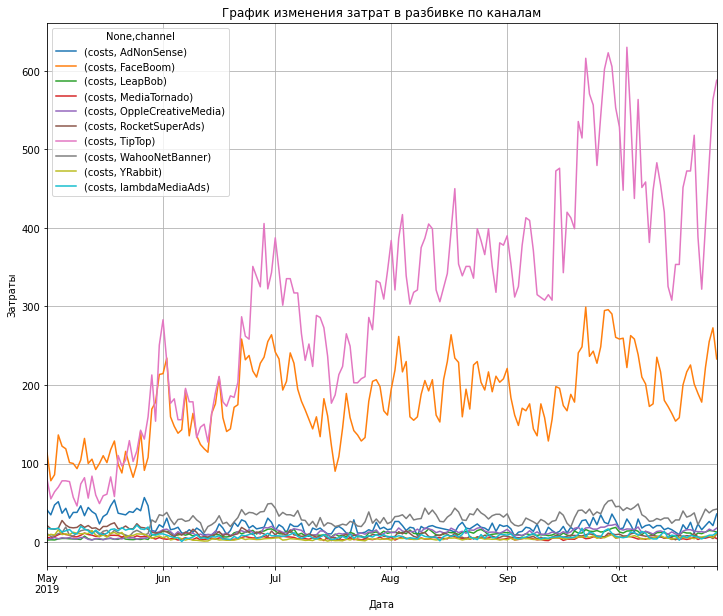

In [51]:
# смотрим изменения расходов во времени по каждому источнику и визиализируем
changes_costs=costs.pivot_table(
               index=["dt"], columns=["channel"], values=["costs"],  aggfunc=sum
)
changes_costs.plot(                                             
           figsize=(12, 10),
           grid=True,)

plt.title('График изменения затрат в разбивке по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

#### Как видно на графике, во всем исследуемом периоде менеджментом приложения отдавалось предпочтение рекламе на FaceBoom и на TipTop. Сначала незначительно, затем расходы на прочие каналы оставались стабильыми, а расходы на эти 2 канала постепенно выросли. При чем, если на FaceBoom возросли и стали стабильными, то расходы на TipTop продолжили рост.

In [52]:
# визуализируем динамику расходов по каналам по месяцам
costs["dt"] = costs["dt"].astype('datetime64[M]')

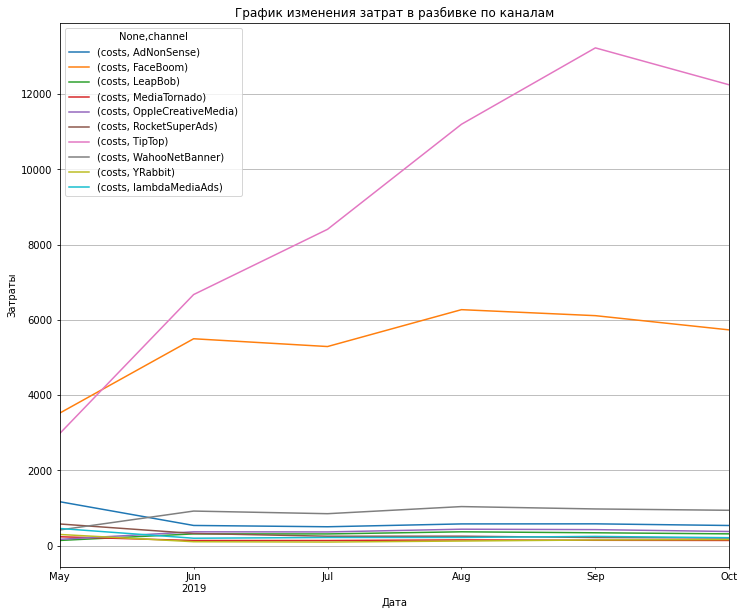

In [53]:
changes_costs=costs.pivot_table(
               index=["dt"], columns=["channel"], values=["costs"],  aggfunc=sum
)
changes_costs.plot(                                             
           figsize=(12, 10),
           grid=True,)

plt.title('График изменения затрат в разбивке по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

In [54]:
# визуализируем динамику расходов по каналам по неделям
costs["dt"] = costs["dt"].astype('datetime64[W]')

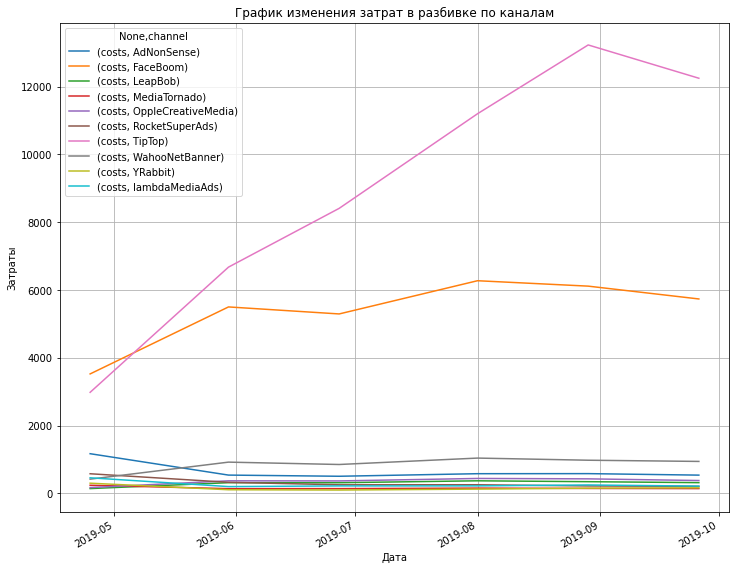

In [55]:
changes_costs=costs.pivot_table(
               index=["dt"], columns=["channel"], values=["costs"],  aggfunc=sum
)
changes_costs.plot(                                             
           figsize=(12, 10),
           grid=True,)

plt.title('График изменения затрат в разбивке по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

In [56]:
profiles['acquisition_cost'].describe()

count    150008.000000
mean          0.703278
std           0.954097
min           0.000000
25%           0.000000
50%           0.247500
75%           1.108943
max           3.715385
Name: acquisition_cost, dtype: float64

#### Примененная функция показала, что средняя трата на привлечение одного пользователя составила 0.7 у.е., медиана - 0.25 у.е.  Вероятно в данных есть какие-то выбросы, которые влияют на большую разницу между средним и медианой. 

In [57]:
# считаем средний CAC по каналам привлечения

cac = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)

cac.sort_values(by='cac', ascending=False).style.format({'cac': '{:.1f}'})

,cac
channel,
TipTop,2.8
FaceBoom,1.1
AdNonSense,1.0
lambdaMediaAds,0.7
WahooNetBanner,0.6
RocketSuperAds,0.4
OppleCreativeMedia,0.2
YRabbit,0.2
MediaTornado,0.2


#### Для приложения Procrastinate Pro+ наиболее затратным стало размещения рекламы в TipTop - в среднем 2,8 у.е./пользователя. Практически в 3р. дешевле обходилось привлечение одного пользователя (CAC) через FaceBoom - 1,1 у.е./пользователя и AdNonSense - 1,0 у.е./пользователя. У остальных 7 платных каналов привлечение 1 пользователя в среднем обходилось 0,7 и менее у.е./пользователя.

#### Вывод по разделу
Общая сумма расходов приложения Procrastinate Pro+ на маркетинг с 1 мая по 27 октября 2019 года составляет 105497,3 у.е.

У приложения при размещении рекламы в каналах есть предпочтения - TipTop перечислено 54751,3 у.е, а FaceBoom - 32445,6 у.е. По каждому из 8 оставшихся каналов расходы составили не более 5151 у.е. Количество проплат за рекламу каналам одинаковое - 180 раз.

График также подтверждает все вышесказанное - менеджментом приложения отдавалось предпочтение рекламе на FaceBoom и на TipTop. Изначально расходы по каналам отличались незначительно, затем расходы на эти 2 канала постепенно выросли, а расходы  на прочие каналы оставались стабильными. При чем, если расходы на FaceBoom возросли и стали стабильными, то расходы на TipTop продолжали расти.

Для приложения наиболее затратным стало размещения рекламы в TipTop - в среднем 2,8 у.е./пользователя. Практически в 3р. дешевле обходилось привлечение одного пользователя (CAC) через FaceBoom - 1,1 у.е./пользователя и AdNonSense - 1,0 у.е./пользователя. У остальных 7 платных каналов привлечение 1 пользователя в среднем обходилось 0,7 и менее у.е./пользователя.

Средняя трата на привлечение одного пользователя составила 0.7 у.е., медиана - 0.25 у.е.  Вероятно в данных есть какие-то выбросы, которые влияют на большую разницу между средним и медианой.

### 5. Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### 5.1 Анализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI

In [58]:
# исключаем пользователей с органическим трафиком
profiles = profiles.query('channel != "organic"')

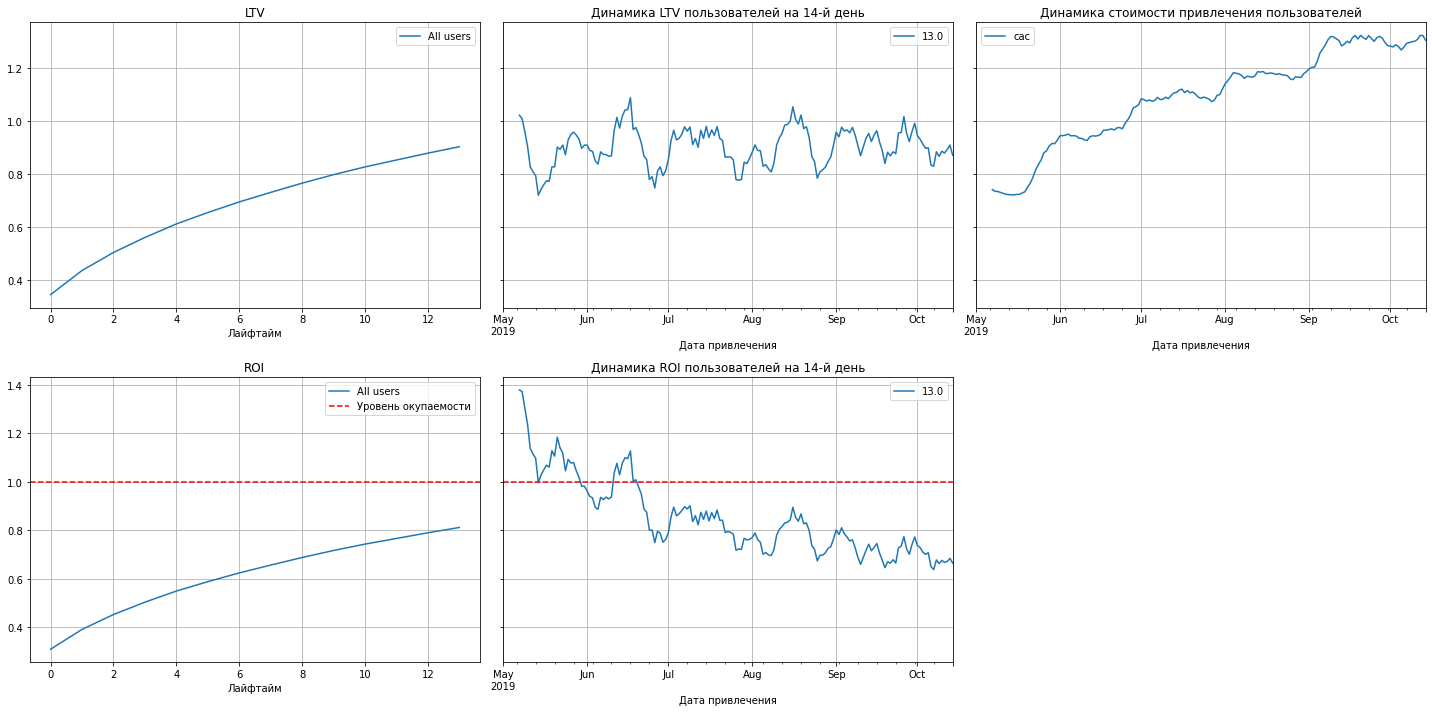

In [59]:
# рассчитываем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

#### Вывод:
1. С середины мая 2019 г. рекламный бюджет приложения постепенно растет.
2. Динамика доходов с клиента (LTV) показывает "пилу". Пики доходности непрерывно чередуются со спадами.
3. Визуализация ROI показывает, что инвестиции так и не достигают точки "безубыточности".
4. ROI пользователей стабильно падает. Впервые рекламный бюджет перестал окупаться в конце мая, затем кратковременный "отскок" и с середины июня уровень окупаемости неуклонно снижается. 

#### 5.2. Cтроим графики конверсии и удержания.

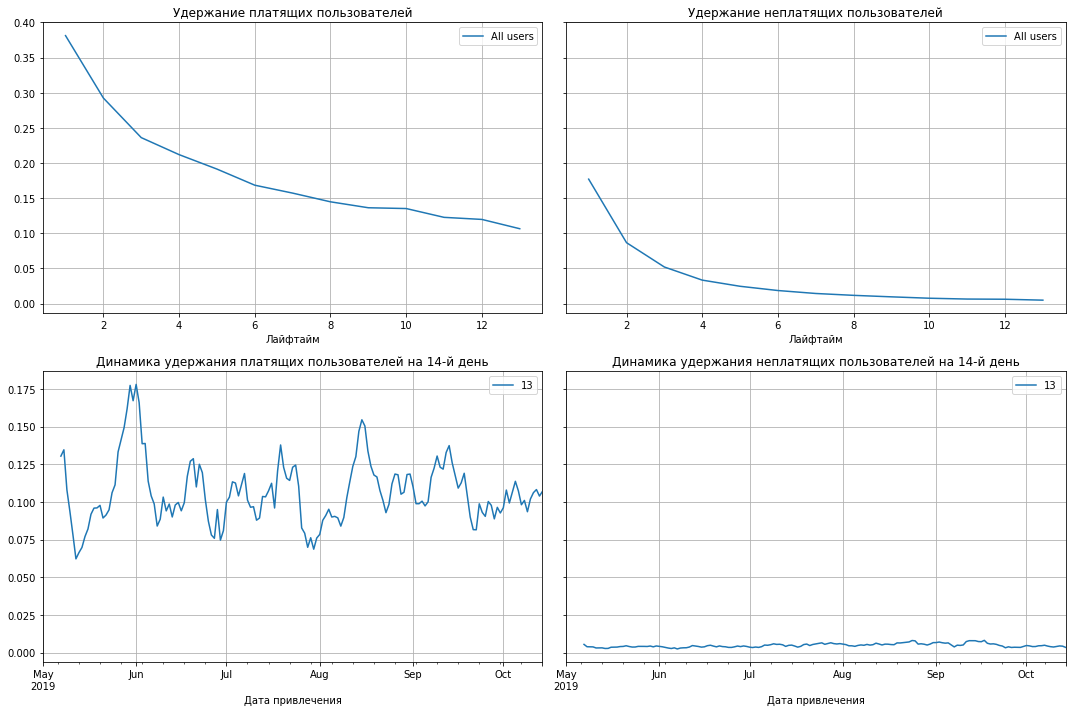

In [60]:
# Посчитаем и визуализируем конверсию, вызвав функции get_retention() и plot_retention()

# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

### 
1. Удержание платящих значительно выше удержания неплатящих - здесь ситуация стандартна. К 13 дню удержание неплатящих стремится к 0. По платящим клиентам за лайфтайм удержание падает с ~40% до ~10%.
2. Если рассматривать ситуацию в динамике, то по неплатящим пользователям удержание за весь период находится в околонулевой отметке. По платящим пользователям удержание хаотично колеблется от 6,0% до 17,5% с беспрерывными пиками и падениями. Чтобы сделать какие-то выводы, ситуацию надо детализировать.

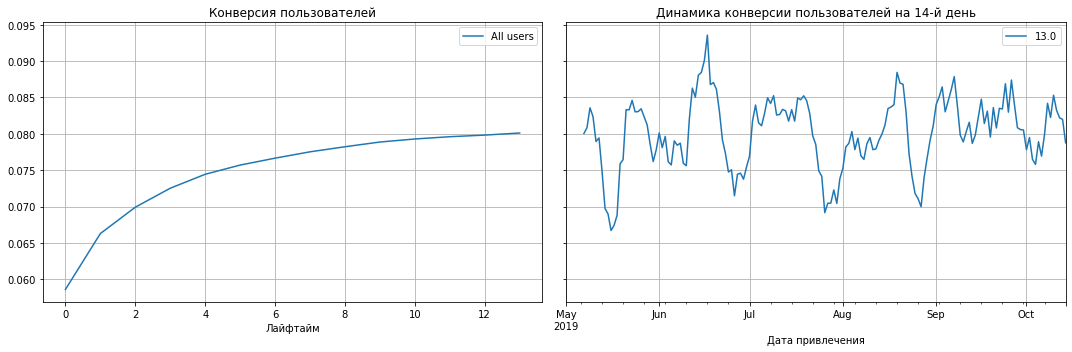

In [61]:
# Посчитаем и визуализируем конверсию, вызвав функции get_conversion() и plot_conversion()

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

#### Конверсия за лайфтайм не снижается - косвенный признак верного расчета. В динамике видим, что в середине мая был провал до ~6,7%. Далее наблюдался рост, но конверсия нестабильна. В пике конверсия достигала ~9,4%

Изучим ситуацию поглубже

###### 5.3 Проанализируем окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

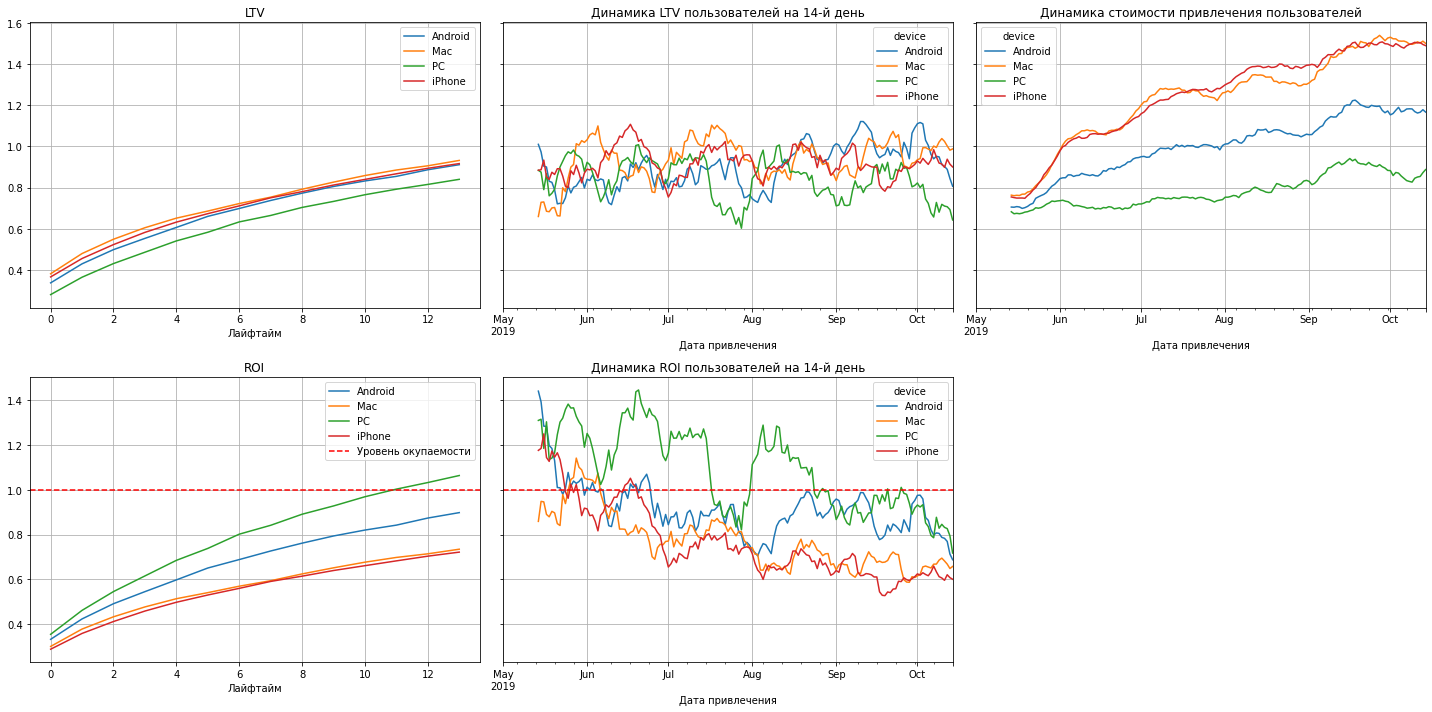

In [62]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### 
1. Стоимость привлечения пользователей по всем устройствам растет. Самая низкая у владельцев РС.
2. Доходность за лайфтайм по всем устройствам примерно одинаковая. Несколько ниже у владельцев РС. В динамике ситуация стабильна.
3. Окупаемость привлечения владельцев РС достигается на 12 день. А вот по владельцам Android и в большей мере iPhone и Mac расходы вообще не окупаются за лайфтайм.
    А по времени - стабильно не окупаются по 3 устройствам примерно с конца июня. В конце августа и по РС окупаемость перестала достигаться. В динамике окупаемость по всем устройствам практически постоянно снижалась. 
4. Эффективность работы по привлечению владельцев РС  выше, т.к. стоимость привлечения ниже, а прибыльность выше. Работа с владельцами Android, iPhone и Mac не окупается, что требует дополнительного внимания

#### 5.4 Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

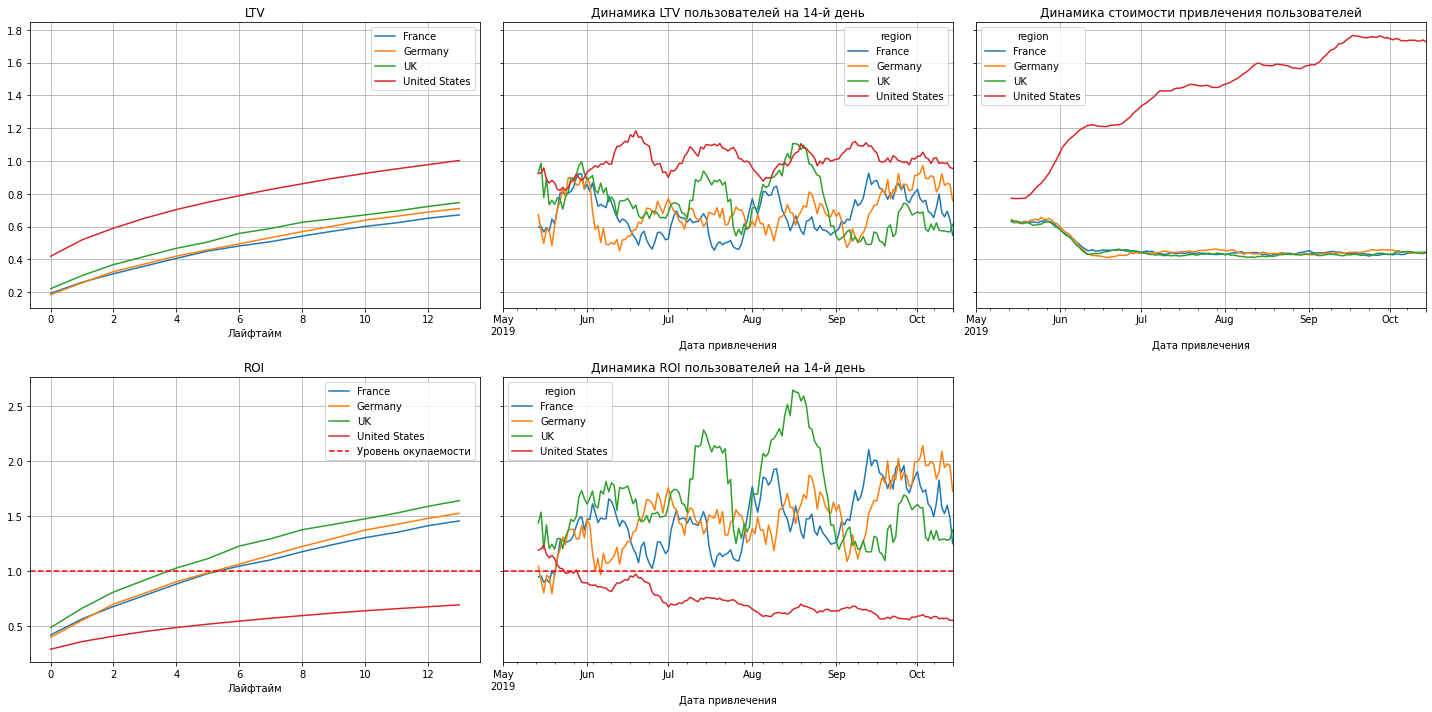

In [63]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### 
1. Стоимость привлечения пользователей по странам примерно одинаковая, кроме США. Там и стоимость значительно выше, чем у остальных и расходы постоянно растут.
2. Доходность за лайфтайм в США несколько выше, чем по 3-м остальным странам. В динамике ситуация схожа, но иногда доходность была выше в Великобритании.
3. Окупаемость привлечения пользователей из Великобритании, Франции и Германии достаточно высока и достигается уже на 5-6 день. А вот по США расходы вообще не окупаются за лайфтайм, а по времени - стабильно примерно с конца мая. В динамике затраты стабильно окупаются по Великобритании, Франции и Германии (кроме кратковременного периода в середине мая). 
4. С середины мая 2019г. расходы по привлечению пользователей из США стабильно выше, чем полученные доходы, что привело к убыточной деятельности в данном сегменте.  

#### 5.4 Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

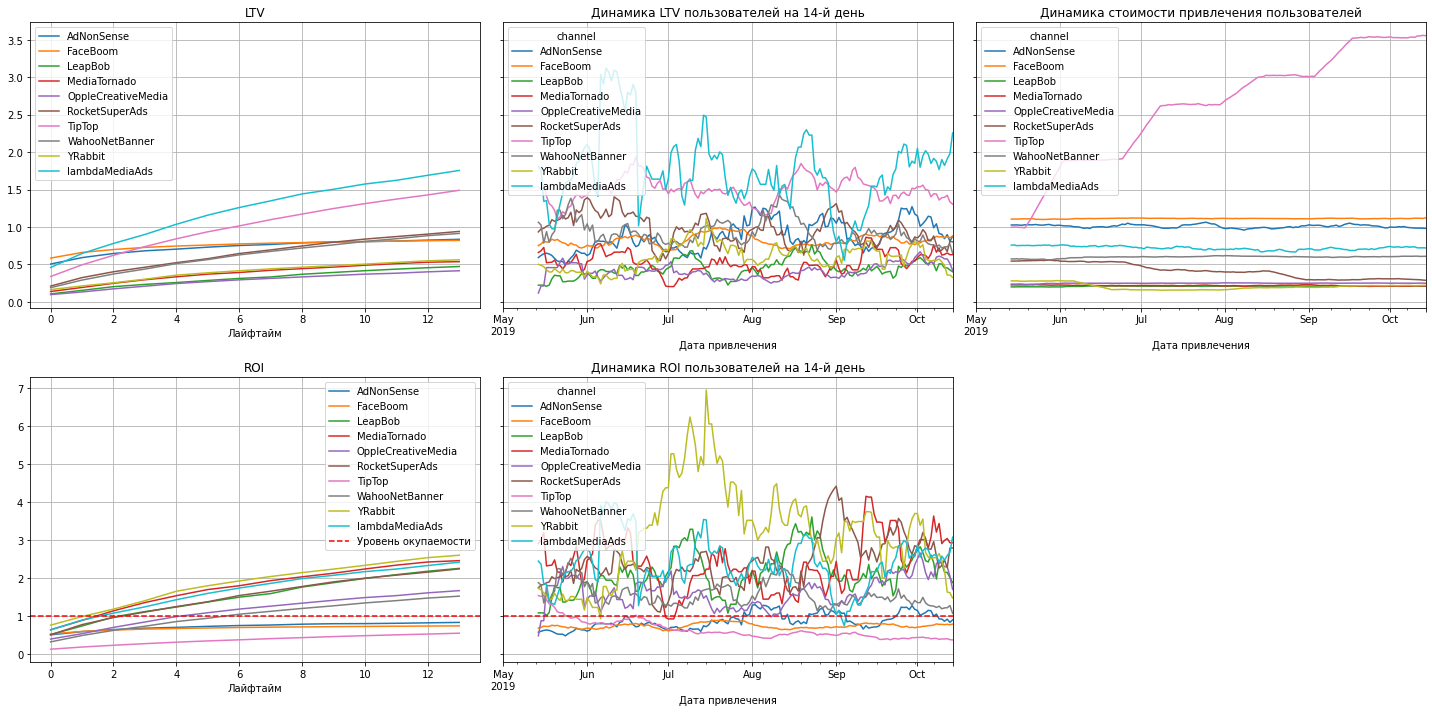

In [64]:
# смотрим окупаемость с разбивкой по рекламным каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

####
1. Доходность на каналах существенно различается. Лучшая у lambdaMediaAds и TipTop.
2. В приложении упор по рекламе сделан на TipTop, расходы по которому стабильно растут. По остальным каналам расходы практически стабильны.
3. Не окупаются к концу 2 недели пользователи из каналов: TipTop, FaceBoom, AdNonSense. В динамике наилучшая окупаемость наблюдается по YRabbit. Вообще не окупаются затраты, проведенные через TipTop и FaceBoom, по большей части через AdNonSense

#### 5.5. Построим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

In [65]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей'.format(horizon))

    plt.tight_layout()
    plt.show() 

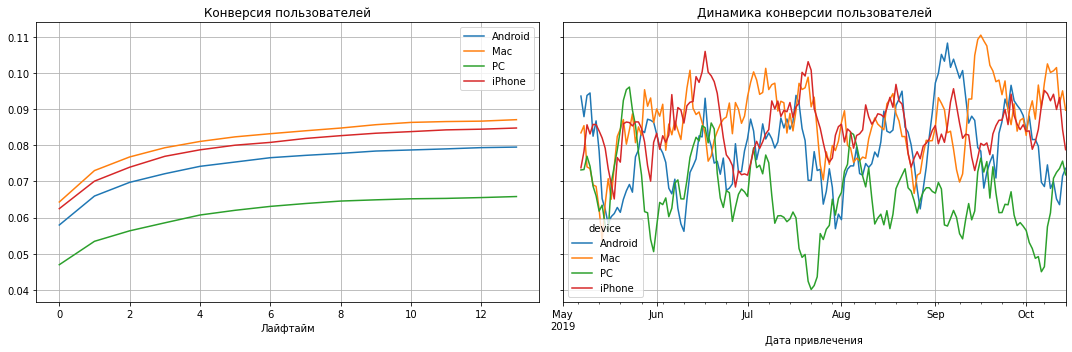

In [66]:
dimensions = ['device']
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

#### Хуже всего конверсия наблюдается по владельцам РС. Лучше всего - по владельцам iPhone и Mac

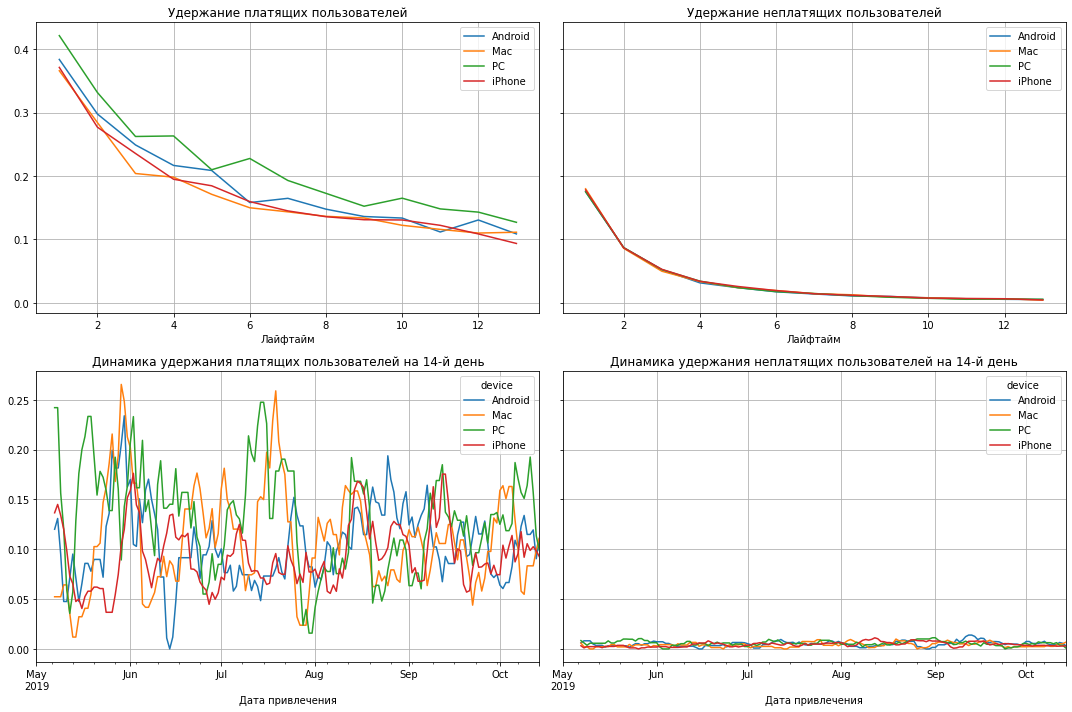

In [67]:
# Смотрим удержание с разбивкой по устройствам
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

####  Не видно, чтобы пользователи каких-то определенных устройств особо плохо удерживались. Неплатящие пользователи удерживаются стабильно плохо, а из платящих лучше всего удерживаются пользователи PC.

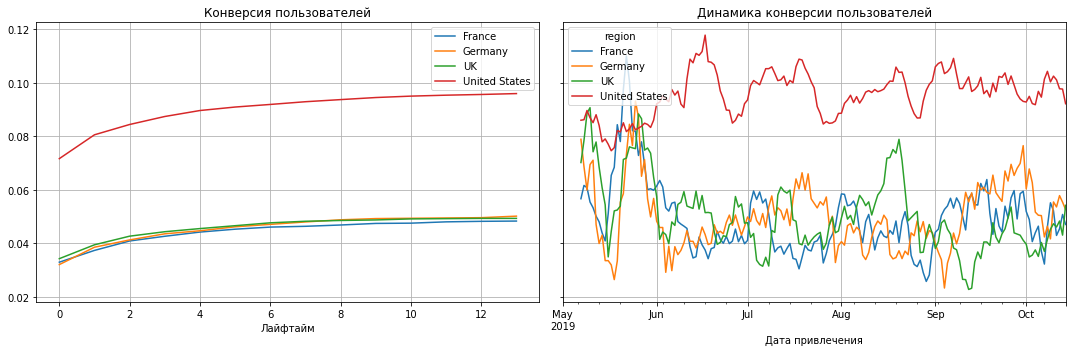

In [68]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

#### Конверсия в США с июня 2019 г. примерно в 2р. лучше, чем в остальных странах

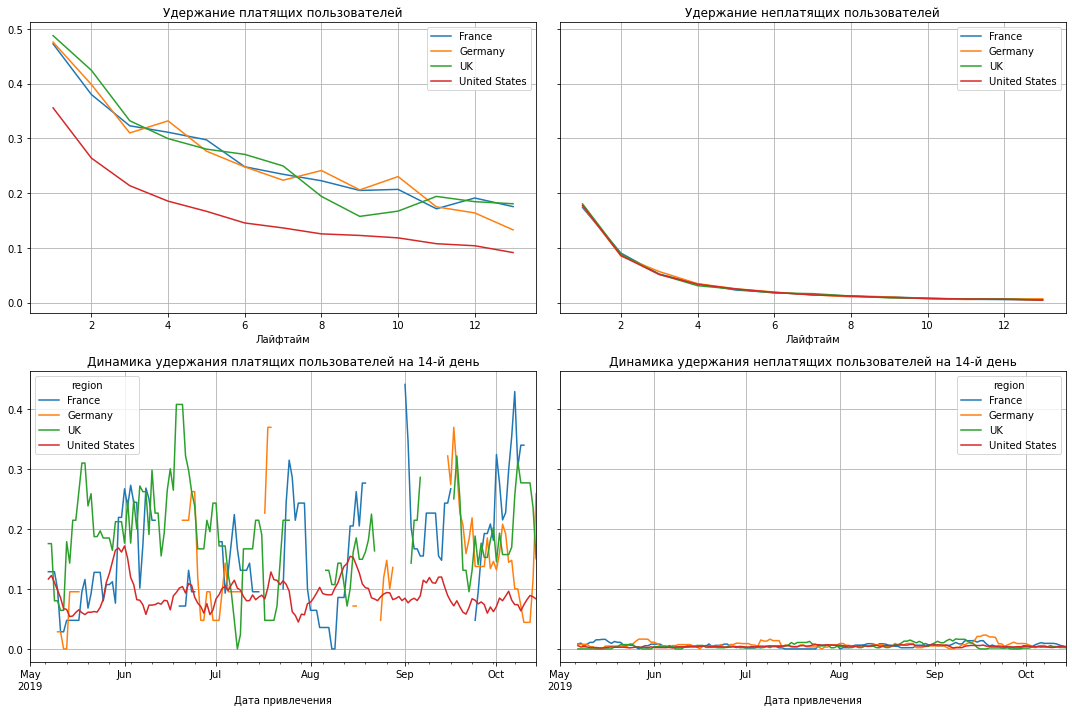

In [69]:
# Смотрим удержание с разбивкой по странам
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### А вот удерживаются платящие пользователи из США практически постоянно хуже, чем в остальных странах.

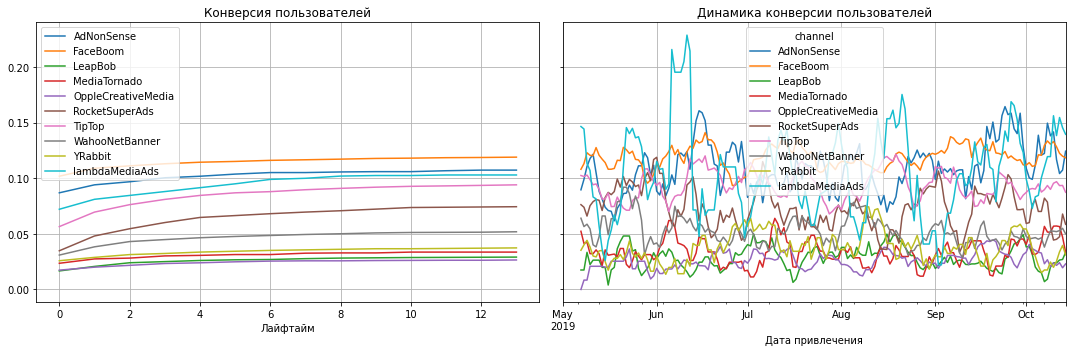

In [70]:
dimensions = ['channel']
# смотрим конверсию с разбивкой по каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

####  Лучшая конврсия у lambdaMediaAds, стабильно хорошая у FaceBoom и TipTop. Плохо конвертируются пользователи из каналов RocketSuperAds, LeapBob, YRabbit.

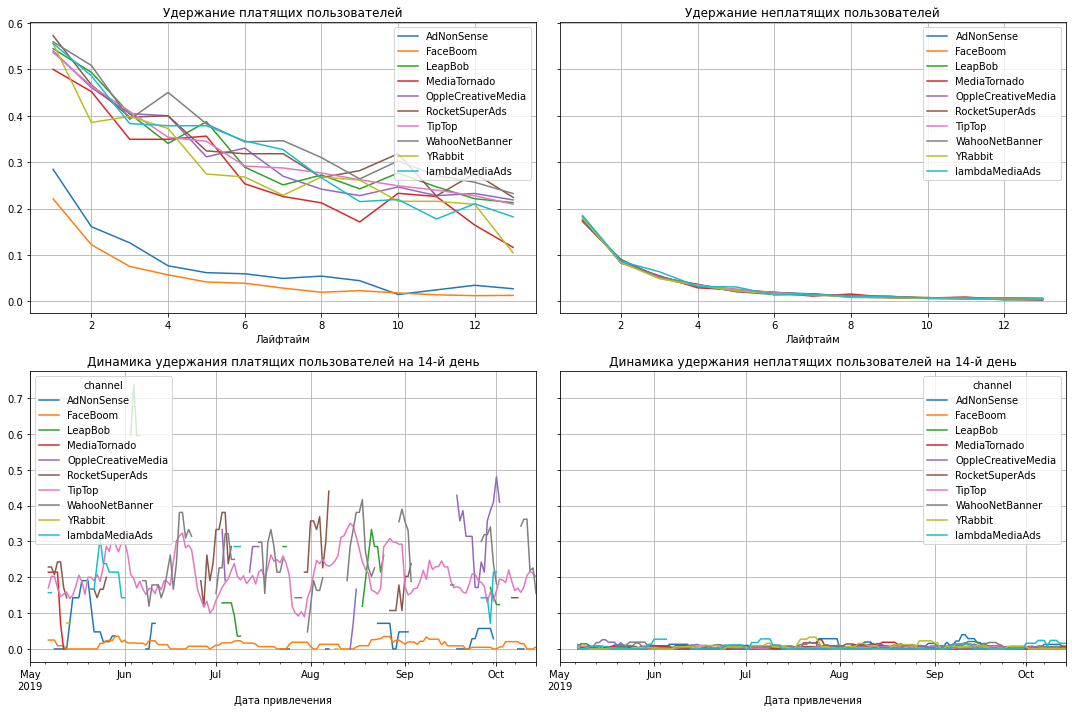

In [71]:
# Смотрим удержание с разбивкой по каналам
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

#### Практически вообще не удерживаются пользователи из канала FaceBoom и чуть лучше AdNonSense. Достаточно хорошо - из TipTop.

### Выводы
Общая сумма расходов приложения Procrastinate Pro+ на маркетинг с 1 мая по 27 октября 2019 года составляет 105497,3 у.е.

С середины мая 2019 г. рекламный бюджет приложения постоянно растет.

Динамика доходов с клиента (LTV) показывает "пилу". Пики доходности непрерывно чередуются со спадами.

Визуализация ROI показывает, что инвестиции так и не достигают точки "безубыточности" за лайфтайм.

ROI пользователей стабильно падает. Впервые рекламный бюджет перестал окупаться в конце мая, затем кратковременный "отскок" и с середины июня уровень окупаемости не достигается.


### Причины неэффективности привлечения пользователей.

Нами делается вывод о неоднозначности некоторых решений, принятых маркетологами приложения.

Подавляющее большинство - 66,7% (или 100002 чел.) пользователей и еще больше платящих пользователей - 77,7% (6902 чел.) приходится на США. Логично, что менеджмент сделал упор на этот сегмент: затраты по привлечению пользователей и LTV здесь значительно выше, чем по остальным странам. Т.е. количественные показатели высокие.

Однако за количественными показателями скрывается отрицательная эффективность вложений. За лайфтайм расходы вообще не окупаются, а по времени - стабильно не окупаются примерно с конца июня.

В то же время конверсия в США с июня 2019 г. примерно в 2р. лучше, чем в остальных странах. А вот удерживаются платящие пользователи из США практически постоянно хуже, чем в остальных странах.


Схожая ситуация и по выбору рекламных каналов. 

Выбор TipTop в качестве основного канала для рекламы можно назвать провальным. Стоимость по привлечению пользователей неуклонно растет, доходность одна из самых высоких. А вот окупаемость затрат на привлечение пользователей с конца мая уже отрицательная и имеет тенденцию к снижению. 

То же самое относится и FaceBoom, второму по величине каналу вложений на рекламу. С той лишь разницей, что TipTop перечислено 54751,3 у.е, а FaceBoom - 32445,6 у.е. Эти расходы также никогда не окупались.

Для приложения наиболее затратным стало размещения рекламы в TipTop - в среднем 2,8 у.е./пользователя. Практически в 3р. дешевле обходилось привлечение одного пользователя (CAC) через FaceBoom - 1,1 у.е./пользователя.

Стабильно хорошая конверсия у FaceBoom и TipTop. Практически вообще не удерживаются пользователи из канала FaceBoom. Достаточно хорошо - из TipTop.

Собственники iPhone и Mac приносят наибольший доход, т.к. менеджмент приложения вкладывает в их привлечение наибольшие средства. Однако с середины июня наблюдается нарастающая отрицательная эффективность вложений. Скорее всего это те же собственники девайсов из США. 

Хуже всего конверсия наблюдается по владельцам РС. Лучше всего - по владельцам iPhone и Mac. Из платящих лучше всего удерживаются пользователи PC.

Возможно присутствуют и какие-то технические проблемы с оптимизацией приложения Procrastinate Pro+ для данных устройств.



Таким образом, общий вывод состоит в том, что усилия, прилагаемые менеджментом приложения, приносят обратно пропорциональный эффект в виде убытков. При чем менеджмент упорствует и наращивает расходы, а следовательно и убытки возрастают.


### Рекомендации для отдела маркетинга.

    Точки роста:
1. Самый "жирный" сегмент приложения по доходам - США. Поэтому необходимо приложить максимум усилий по резкому повышению эффективности вложений. Возможно каналы распространения рекламы в этой стране не подходят местной аудитории. Возможно имеются какие-то технические проблемы, т.к. удержание пользователей в США стабильно хуже, чем в других странах.
2. Пользователи из Великобритании, Франции и Германии плохо переходят из категории "посетители" в категорию "покупатели". Однако по тем, кто остался окупаемость привлечения пользователей из этих стран достаточно высока и достигается уже на 5-6 день. В динамике затраты стабильно окупаются по этим 3-м странам. Необходимо найти оптимальные продукты для пользователей. Требуется также посмотреть на возможные технические "неудобства" для пользователей из-за "невысокой" относительно США конверсии.
3. По нашему мнению необходимо отказаться от затратной рекламы в TipTop. Конверсия и удержание есть, а эффективность - отрицательная. По ТОП2 затратному каналу FaceBoom - при хорошей конверсии необходимо установить проблему удержания клиентов. Если она неразрешима, то также отказываться или существенно снижать расходы здесь.
4. Возможно нарастить на рекламу в YRabbit - здесь наблюдается в динамике наилучшая окупаемость. Зато плохая конверсия и удержание. Или lambdaMediaAds, где отличная конверсия, хорошее удержание и доходность, стабильная прибыльность. 
   Т.е. пересмотреть рекламную политику, переставить акценты. Возможно обратить внимание как на транснациональные социальные сети, так и на местные.
5. Худшая конверсия у РС и лучшее удержание. Низкая стоимость привлечения, стабильно хорошая доходность, большую часть времени - достаточно высокая окупаемость. Здесь есть какой-то технический сбой.
